# 3.1. Classification with Logistic Regression

### Import libraries and load the dataset

In [110]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count

In [111]:
spark = SparkSession.builder.appName("Structured_API").getOrCreate()

In [112]:
data = spark.read.csv("../../data/creditcard.csv", header=True, inferSchema=True)

### 3.1.1. Structured API Implementation (High-Level)


**a. Preprocess your data appropriately (e.g., handle missing values and standardize features if necessary).**

- First, we will observer the data and check for missing values.

In [113]:
print(f"Number of rows: {data.count()}")

Number of rows: 284807


In [114]:
data.show()

+----+------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|                V3|                 V4|                 V5|                 V6|                  V7|                 V8|                V9|                V10|               V11|               V12|                V13|                V14|                V15|                V16|                 V17|                V18|                V19|                V20|                 V

In [115]:
data.printSchema()


root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [116]:
data.describe().toPandas()

,summary,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,count,284807,284807,284807,284807,284807,284807,284807,284807,284807,...,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807
1,mean,94813.85957508067,2.3120013345304016E-15,3.001769688478698E-16,1.647779956654264E-15,1.5839125164738662E-15,-8.430502103812514E-16,1.5807191444648464E-15,-5.843870776506401E-16,-1.528826849318273E-16,...,2.770250217824756E-16,-8.318734083496817E-16,2.4908301670355153E-16,4.465631375988472E-15,3.4488417697414826E-16,1.6140499648089914E-15,-3.779156186924478E-16,-1.247410941023395E-16,88.34961925094233,0.001727485630620034
2,stddev,47488.14595456595,1.9586958038574855,1.6513085794769953,1.5162550051777728,1.4158685749409223,1.380246734031438,1.332271089757576,1.2370935981826678,1.1943529026692048,...,0.734524014371313,0.7257015604409108,0.6244602955949896,0.6056470678271609,0.5212780705409429,0.48222701326105755,0.40363249496503156,0.33008326416025063,250.12010924018833,0.04152718963546499
3,min,0.0,-56.407509631329,-72.7157275629303,-48.3255893623954,-5.68317119816995,-113.743306711146,-26.1605059358433,-43.5572415712451,-73.2167184552674,...,-34.8303821448146,-10.933143697655,-44.8077352037913,-2.83662691870341,-10.2953970749851,-2.60455055280817,-22.5656793207827,-15.4300839055349,0.0,0
4,max,172792.0,2.45492999121121,22.0577289904909,9.38255843282114,16.8753440335975,34.8016658766686,73.3016255459646,120.589493945238,20.0072083651213,...,27.2028391573154,10.5030900899454,22.5284116897749,4.58454913689817,7.51958867870916,3.5173456116238,31.6121981061363,33.8478078188831,25691.16,1


In [117]:
null_counts = data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns])
null_counts.show()

+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



In [118]:
data = data.dropna()

- We can see that there are **no missing values** in the dataset.

- Next, we check for duplicates.

In [119]:
duplicate_count = data.groupBy(data.columns).count().filter(col("count") > 1).count()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 773


In [120]:
data = data.dropDuplicates()
print(f"Number of rows: {data.count()}, Number of columns: {len(data.columns)}")

Number of rows: 283726, Number of columns: 31


In [121]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Assemble feature columns into a single vector column
feature_columns = data.columns[:-1]  # Assuming the last column is the label
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_with_features = assembler.transform(data).select("features", "Class")

# Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(data_with_features)
data_preprocessed = scaler_model.transform(data_with_features)

data_preprocessed.show()

+--------------------+-----+--------------------+
|            features|Class|      scaledFeatures|
+--------------------+-----+--------------------+
|[26.0,-0.52991228...|    0|[5.47586903724098...|
|[158.0,-0.6008163...|    0|[0.00332764349186...|
|[190.0,-1.5057791...|    0|[0.00400159660413...|
|[265.0,-0.4910030...|    0|[0.00558117421103...|
|[459.0,-0.5282175...|    0|[0.00966701495420...|
|[775.0,-3.9008102...|    0|[0.01632230193792...|
|[926.0,-1.5369580...|    0|[0.01950251818648...|
|[943.0,-1.2125020...|    0|[0.01986055577737...|
|[1261.0,-0.883528...|    0|[0.02655796483061...|
|[1293.0,-1.434347...|    0|[0.02723191794289...|
|[1490.0,-0.798976...|    0|[0.03138094179034...|
|[1579.0,-0.651215...|    0|[0.03325537388385...|
|[1844.0,1.1153481...|    0|[0.03883654809489...|
|[1993.0,1.0095755...|    0|[0.04197464227392...|
|[2045.0,-2.251741...|    0|[0.04306981608137...|
|[2095.0,-0.444487...|    0|[0.04412286781930...|
|[2106.0,-1.319168...|    0|[0.04435453920165...|


- Next, we explore the features' distributions

In [122]:
df_pandas = data.toPandas()

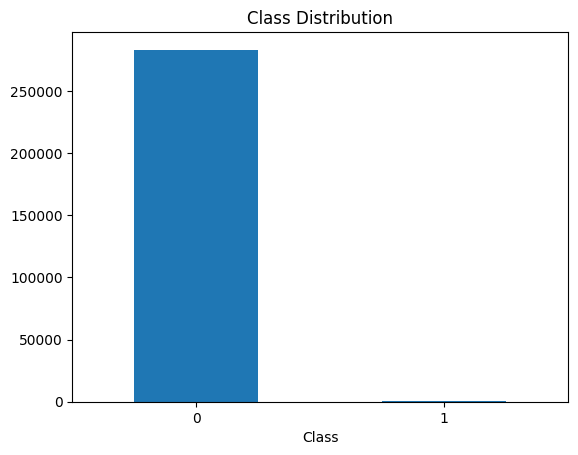

In [123]:
df_pandas['Class'].value_counts(sort=False).plot.bar(
    title="Class Distribution",
    rot=0,
);

In [124]:
# spark.stop()